In [3]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# Enter the foldername in your Drive where you have saved the unzipped
# assignment folder
FOLDERNAME = 'Stanford/final_project/'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Tutorial followed: https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler, Subset
import torch.nn.functional as F

import torchvision.datasets as dset
import torchvision.transforms as T
from torchvision import models
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
%matplotlib inline

import copy
import os
import time

import pandas as pd
import numpy as np

USE_GPU = True
dtype = torch.float32 # We will be using float throughout this tutorial.

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss.
# print_every = 300
batch_size = 64
len_data = 12800
input_size = 224
drop_prob = 0.3
data_dir = '/content/drive/My Drive/Stanford/final_project/top_20/'
print('using device:', device)

using device: cuda


In [5]:
classes = os.listdir(data_dir)

In [6]:
train_tfms = T.Compose([
    T.Resize(input_size), 
    T.ToTensor()
])

all_data = ImageFolder(data_dir, transform=train_tfms)
num_classes = len(all_data.class_to_idx)
all_data = Subset(all_data, np.random.choice(len(all_data), len_data, replace=False))
print(all_data[0][0].shape)
print(len(all_data))

train_len = int(len_data*0.7)
val_len = int(len_data*0.2)
test_len = len_data - (train_len + val_len)
train, val, test = torch.utils.data.random_split(all_data, [train_len, val_len, test_len])
train_dl = DataLoader(train, batch_size, num_workers=2, shuffle=True, pin_memory=True)
val_dl = DataLoader(val, batch_size, num_workers=2, shuffle=True, pin_memory=True)
test_dl = DataLoader(test, batch_size, shuffle=True, pin_memory=True)

dataloaders = {'train': train_dl, 'val': val_dl}

torch.Size([3, 224, 224])
12800


In [7]:
def train_model(model, dataloaders, criterion, optimizer, name='inception_v3_generic', num_epochs=25, is_inception=True, optimizer_lr=None):
    since = time.time()

    val_acc_history = []
    val_acc3_history = []
    train_acc_history = []
    train_acc3_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            running_corrects3 = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                # acc@3
                _, pred = outputs.topk(3, 1, True, True)
                pred = pred.t()
                correct = pred.eq(labels.view(1, -1).expand_as(pred))
                correct_k = correct[:3].reshape(-1).float().sum(0)
                running_corrects3 += correct_k

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            epoch_acc3 = running_corrects3.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f} Acc@3: {:.4f}'.format(phase, epoch_loss, epoch_acc, epoch_acc3))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                print('Saving model...')
                torch.save(model.state_dict(), f'/content/drive/My Drive/{FOLDERNAME}results/{name}.pth')
            if phase == 'val':
                val_acc_history.append(epoch_acc.item())
                val_acc3_history.append(epoch_acc3.item())
            else: 
                train_acc_history.append(epoch_acc.item())
                train_acc3_history.append(epoch_acc3.item())
            
        if optimizer_lr is not None: 
          optimizer_lr.step()

        print("Saving training history...")
        data = pd.DataFrame(
            {'epoch': list(range(epoch + 1)), 
             'train_acc': train_acc_history, 
             'val_acc': val_acc_history, 
             'train_acc3': train_acc3_history, 
             'val_acc3': val_acc3_history})
        data.to_csv(f'/content/drive/My Drive/{FOLDERNAME}results/{name}.csv')
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [8]:
def set_parameter_requires_grad(model, feature_extracting=True): 
  if feature_extracting: 
    for param in model.parameters(): 
      param.requires_grad = False

In [9]:
def initialize_model(num_classes, feature_extract=True, use_pretrained=True): 
  model_ft = models.resnet50(pretrained=use_pretrained)
  set_parameter_requires_grad(model_ft, feature_extract)
  num_ftrs = model_ft.fc.in_features
  model_ft.fc = nn.Sequential(
      nn.Dropout(drop_prob), 
      nn.Linear(num_ftrs, 512), 
      nn.ReLU(), 
      nn.Dropout(drop_prob), 
      nn.Linear(512, num_classes), 

  )
  # model_ft.fc = nn.Sequential(nn.Dropout(drop_prob), nn.Linear(num_ftrs, num_classes))
  return model_ft, input_size

model_ft, input_size = initialize_model(num_classes, True, True)
print(model_ft)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1,

In [10]:
# Send model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized / updated in this run. If we are
# finetuning we will be updating all parameters. However, if we are doing
# feature extract method, we will only update the parameters that we have 
# just initialized, i.e. the parameters with requires_grad = True
params_to_update = model_ft.parameters()
print("Params to learn:")
params_to_update = []
for name, param in model_ft.named_parameters():
  if param.requires_grad == True: 
    params_to_update.append(param)
    print('\t', name)
# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(params_to_update, lr=0.001)

Params to learn:
	 fc.1.weight
	 fc.1.bias
	 fc.4.weight
	 fc.4.bias


In [11]:
def load_model(model, path): 
  '''
  Load model from saved parameters.
  '''
  model.load_state_dict(torch.load(path, map_location=torch.device('cpu')))
  model.to(device)
  model.eval()
  return model

model = load_model(model_ft, f'/content/drive/My Drive/{FOLDERNAME}results/resnet50_pretrained_30_epochs_top_20_adam_twolayer_dropout03_lrdecay_5_05.pth')

In [12]:
val = dataloaders['val']

@torch.no_grad()
def get_all_preds(model, loader):
    all_preds = torch.tensor([]).to(device)
    all_labels = torch.tensor([]).to(device)
    for batch in loader:
        images, labels = batch
        images = images.to(device)
        labels = labels.to(device)

        preds = model(images)
        all_preds = torch.cat(
            (all_preds, preds)
            ,dim=0
        )

        all_labels = torch.cat((all_labels, labels), dim=0)
    return all_preds, all_labels

preds, targets = get_all_preds(model, val)

print(preds)

tensor([[-11.6565,  -9.1705,  -3.2624,  ...,   6.4749,   2.5960,  10.8712],
        [ -7.0283,  -1.8561,  -0.6824,  ...,  -1.3346,  -1.2373,  -1.6519],
        [ -7.7190,  -3.8709,   1.6372,  ...,   5.2585,   2.7847,  -1.3666],
        ...,
        [ -7.8483,   2.5567,   5.8116,  ...,  -0.9255,  -3.5703,  -4.9166],
        [ -8.5229,  -4.4350,  -2.2699,  ...,   9.1908,   2.9037,   3.5419],
        [-13.5187,   1.4755,   0.0148,  ...,  -1.9452,   0.5677,  -2.5933]],
       device='cuda:0')


In [13]:
stacked = torch.stack(
    (
        targets, preds.argmax(dim=1)
    ), 
    dim=1
)
print(stacked.shape)
cmt = torch.zeros(num_classes, num_classes, dtype=torch.int64)
for p in stacked: 
  t1, p1 = p.tolist()
  t1 = int(t1)
  p1 = int(p1)
  cmt[t1, p1] = cmt[t1, p1] + 1
print(cmt)

torch.Size([2560, 2])
tensor([[ 58,   0,   0,   0,   0,   0,   1,   1,   1,   0,   0,   0,   2,   3,
           0,   1,   0],
        [  0,  51,  32,   0,   0,   0,   1,   1,   2,   0,   1,   0,  11,   0,
           1,   0,   1],
        [  0,   7, 345,   5,   2,   0,   4,   6,   3,   0,   2,   0,  15,   0,
           7,   1,   1],
        [  0,   0,  15,  63,   1,   1,   2,   0,   1,   0,   0,   0,   6,   1,
           0,   0,   0],
        [  0,   0,   1,   2,  54,   3,   0,   0,   0,   0,   0,   0,   0,   0,
           3,   0,   3],
        [  1,   0,   0,   1,   2,  84,   4,   1,   0,   0,   0,   0,   1,   0,
           0,   0,   2],
        [  1,   0,   2,   1,   0,   4, 187,   3,   0,   1,   5,   0,   8,   7,
          14,   2,   6],
        [  0,   1,   3,   1,   0,   0,   1,  99,   1,   0,   0,   0,   2,   1,
           3,   0,   1],
        [  0,   0,   6,   0,   0,   0,   0,   1,  71,   1,   1,   0,   2,   0,
           0,   0,   0],
        [  0,   1,   4,   0,   1,   0,   6

Normalized confusion matrix, ResNet
[[0.86567164 0.         0.         0.         0.         0.
  0.01492537 0.01492537 0.01492537 0.         0.         0.
  0.02985075 0.04477612 0.         0.01492537 0.        ]
 [0.         0.5049505  0.31683168 0.         0.         0.
  0.00990099 0.00990099 0.01980198 0.         0.00990099 0.
  0.10891089 0.         0.00990099 0.         0.00990099]
 [0.         0.01758794 0.86683417 0.01256281 0.00502513 0.
  0.01005025 0.01507538 0.00753769 0.         0.00502513 0.
  0.03768844 0.         0.01758794 0.00251256 0.00251256]
 [0.         0.         0.16666667 0.7        0.01111111 0.01111111
  0.02222222 0.         0.01111111 0.         0.         0.
  0.06666667 0.01111111 0.         0.         0.        ]
 [0.         0.         0.01515152 0.03030303 0.81818182 0.04545455
  0.         0.         0.         0.         0.         0.
  0.         0.         0.04545455 0.         0.04545455]
 [0.01041667 0.         0.         0.01041667 0.02083333 0

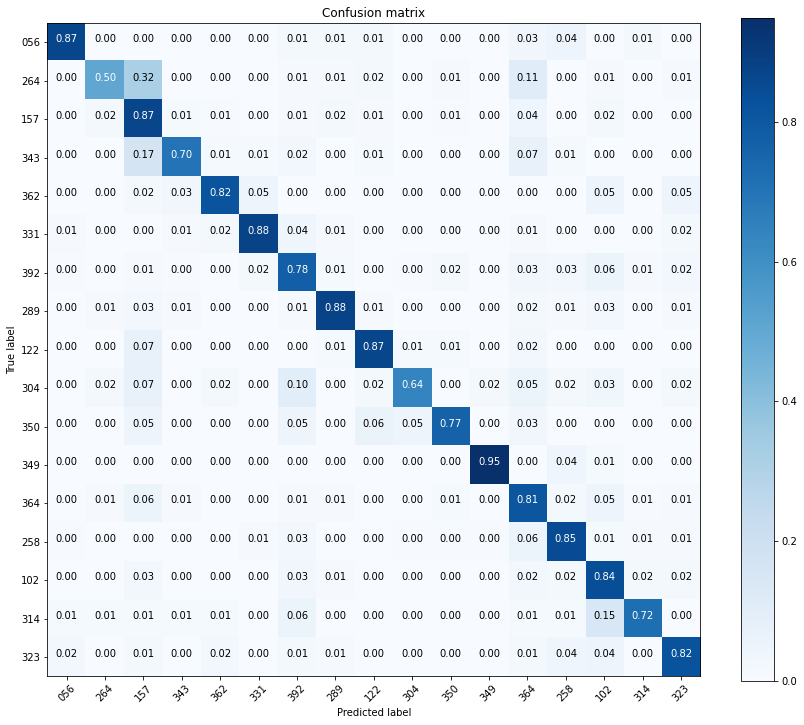

In [15]:
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(targets.cpu(), preds.cpu().argmax(dim=1))

import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues, name='plot'):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix, ResNet")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(f'/content/drive/My Drive/{FOLDERNAME}results/{name}.png')

plt.figure(figsize=(12, 10))
plot_confusion_matrix(cm, classes, normalize=True,name='confusion_matrix_resnet_normalized')

In [ ]:
print((targets == preds.argmax(dim=1)).float().mean())

tensor(0.0891)


In [ ]:
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders, criterion, optimizer_ft, name='resnet50_pretrained_30_epochs_all_adam_threelayer_dropout03', num_epochs=30, is_inception=False)

Epoch 0/29
----------
train Loss: 4.0650 Acc: 0.1786 Acc@3: 0.3290
val Loss: 3.3946 Acc: 0.3012 Acc@3: 0.4707
Saving model...
Saving training history...

Epoch 1/29
----------
train Loss: 3.3228 Acc: 0.2855 Acc@3: 0.4586
val Loss: 2.9509 Acc: 0.3598 Acc@3: 0.5438
Saving model...
Saving training history...

Epoch 2/29
----------
train Loss: 3.0037 Acc: 0.3215 Acc@3: 0.5142
val Loss: 2.7673 Acc: 0.3859 Acc@3: 0.5805
Saving model...
Saving training history...

Epoch 3/29
----------
train Loss: 2.7939 Acc: 0.3508 Acc@3: 0.5527
val Loss: 2.5897 Acc: 0.4102 Acc@3: 0.6070
Saving model...
Saving training history...

Epoch 4/29
----------
train Loss: 2.6206 Acc: 0.3772 Acc@3: 0.5770
val Loss: 2.5170 Acc: 0.4184 Acc@3: 0.6121
Saving model...
Saving training history...

Epoch 5/29
----------
train Loss: 2.4934 Acc: 0.3887 Acc@3: 0.6013
val Loss: 2.4564 Acc: 0.4301 Acc@3: 0.6285
Saving model...
Saving training history...

Epoch 6/29
----------
train Loss: 2.3808 Acc: 0.4033 Acc@3: 0.6224
val Loss:

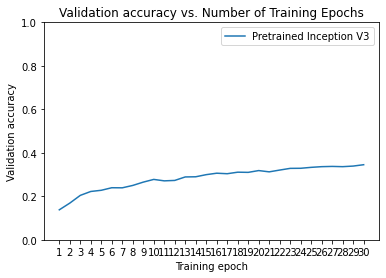

In [ ]:
# Plot the training curve of validation accuracy vs. number of epochs
ohist = hist

plt.title("Validation accuracy vs. Number of Training Epochs")
plt.xlabel("Training epoch")
plt.ylabel("Validation accuracy")
plt.plot(range(1, 31), ohist, label="Pretrained Inception V3")
plt.ylim((0, 1.))
plt.xticks(np.arange(1, 31, 1.0))
plt.legend()
plt.show()